### 1. Simple DCGAN Model

In [ ]:
import sklearn
assert sklearn.__version__ >= "0.20"


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import gdown
from zipfile import ZipFile
assert tf.__version__ >= "2.0"
from glob import glob
from IPython.display import Image
import PIL
import random

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print('Libraries imported!')

Libraries imported!


In [ ]:
#Check if we run on GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 10 04:49:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# ####Mount GG drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load in the celebA dataset

In [ ]:
#Download the celebA dataset from google drive and unzip it

os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
#Create the dataset (64x64)

dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64)
)
dataset = dataset.map(lambda x: x / 255.0)

#Note: the model would generate higher quality images if we train on 128x128, but it's much more 
#computationally expensive.

Found 202599 files belonging to 1 classes.


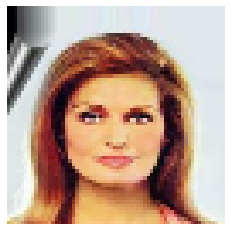

In [ ]:
#Display 1 random image with the resolution of 64x64

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


There are 202599 images in the dataset


There are 202599 images in the dataset


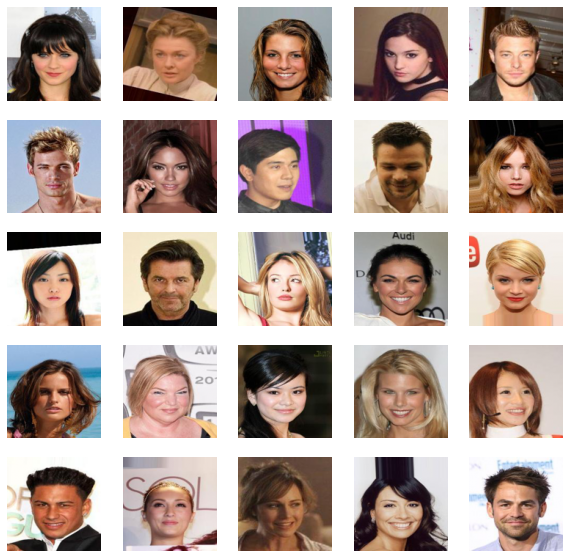

In [ ]:
#Display random 25 images with higher resolution (128x128)

images_paths = glob('celeba_gan/img_align_celeba/*')
print('There are {} images in the dataset'.format(len(images_paths)))

def resize_image(path, image_size=(128, 128)):
  return np.asanyarray(PIL.Image.open(path).resize(image_size))/255

plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(resize_image(random.sample(images_paths, 25)[i]))
  plt.axis('off')
plt.show()

# Create the generator and discriminator

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

## The Discriminator
The discriminator is a CNN-based images classifier to classify the images generated by the generator whether *real* or *fake*. The model will be trained to output positive values for *real images* and negative for *fake images*.

In [ ]:
discriminator = keras.Sequential(
    [
        #The input images have shape of 64x64 with 3 color channel (RGB)
        keras.Input(shape=(64, 64, 3)),

        #Now we just add regular CNN layers and use LeakyReLU as our
        #activation function
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),

        #Flatten
        layers.Flatten(),

        #Use 20% Dropout to prevent overfiiting
        layers.Dropout(0.2),

        #We use sigmoid as our output activation function since the 
        #discriminator will classify either the image is fake or real (binary)
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)           

## The Generator
The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. We use `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses `sigmoid`

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8  * 128),
        layers.Reshape((8, 8, 128)),

        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       524544    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 512)       2097664   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       41

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        #Get the trainable weights and update them
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble real images labels
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

#Add callbacks.ModelCheckpoint to avoid long training time
# cp_callback = keras.callbacks.ModelCheckpoint(filepath='training_callbacks/', 
#                                               save_weights_only=True, verbose=1)

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        plt.figure(figsize=(12,6))
        for i in range(self.num_img):
            plt.subplot(2, 5, i+1)
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            #img.save("gdrive/MyDrive/saved_files/generated_images/generated_img_%03d_%d.png" % (epoch, i))
            plt.imshow((generated_images[i] / 255).numpy())
            plt.axis('off')
        
        #plt.savefig('samples/sample_128x128_%d.png' % (epoch))


# Model Training

Epoch 1/5
6332/6332 [==============================] - 1505s 235ms/step - d_loss: 0.6172 - g_loss: 1.3687
Epoch 2/5
6332/6332 [==============================] - 1486s 235ms/step - d_loss: 0.6429 - g_loss: 1.1735
Epoch 3/5
6332/6332 [==============================] - 1487s 235ms/step - d_loss: 0.6215 - g_loss: 1.2092
Epoch 4/5
6332/6332 [==============================] - 1488s 235ms/step - d_loss: 0.5986 - g_loss: 1.3135
Epoch 5/5
6332/6332 [==============================] - 1489s 235ms/step - d_loss: 0.6109 - g_loss: 1.1663


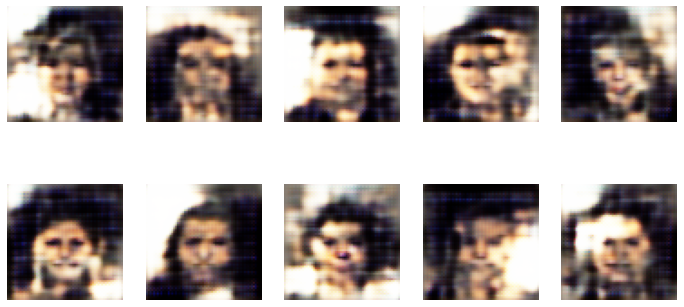

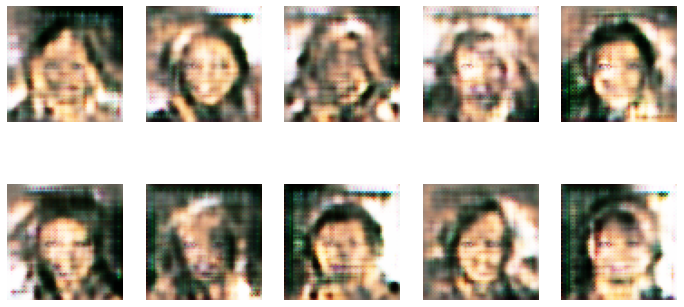

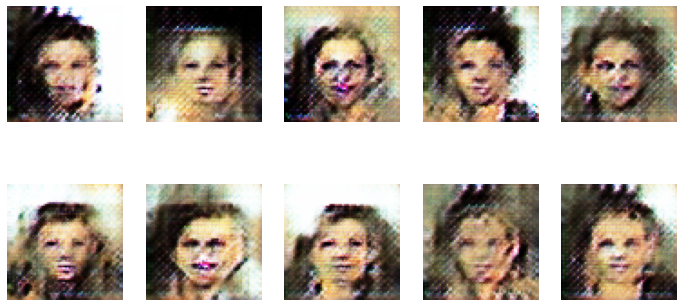

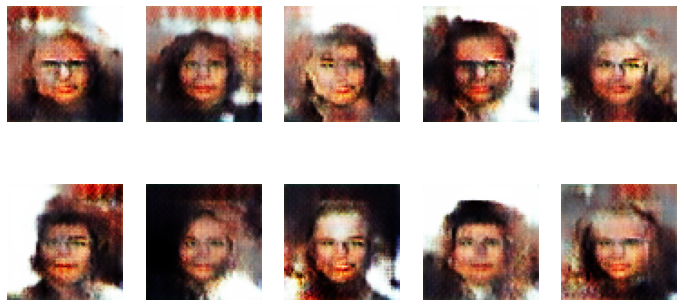

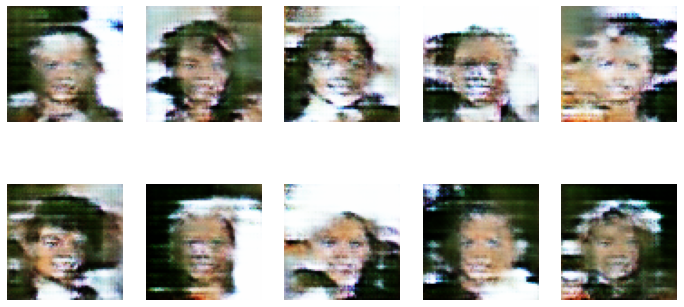

In [ ]:
epochs = 5  # For demonstration, I use 5 epochs; but in practice, it is recommended to use ~100 epochs

#create GAN model
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compile it
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

#20k images and 100 epochs with this model will result in ~5hr training time.
#40k images (128x128) and 30 epochs with this model will result in ~4.5hr training time.
#60k images (128x128) and 30 epochs with this model will result in ~7hr training time.

Epoch 1/4
6332/6332 [==============================] - 2782s 437ms/step - d_loss: 0.6543 - g_loss: 1.2027

Epoch 00001: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 2/4
6332/6332 [==============================] - 2764s 437ms/step - d_loss: 0.6788 - g_loss: 1.0785

Epoch 00002: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 3/4
6332/6332 [==============================] - 2763s 436ms/step - d_loss: 0.6919 - g_loss: 1.0491

Epoch 00003: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 4/4
6332/6332 [==============================] - 2763s 436ms/step - d_loss: 0.6944 - g_loss: 0.9965

Epoch 00004: saving model to gdrive/MyDrive/saved_files/training_callbacks/


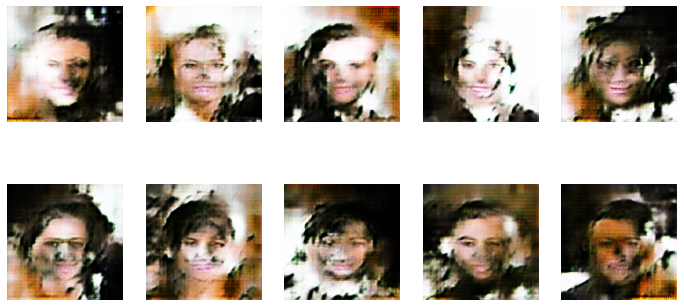

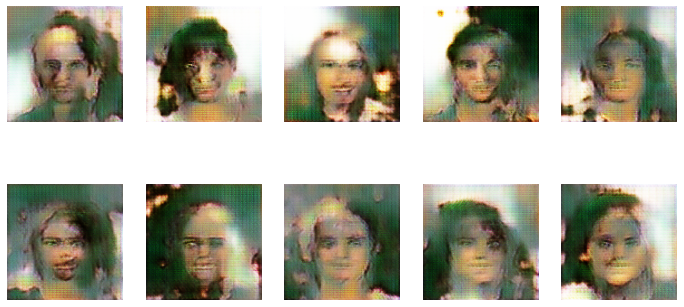

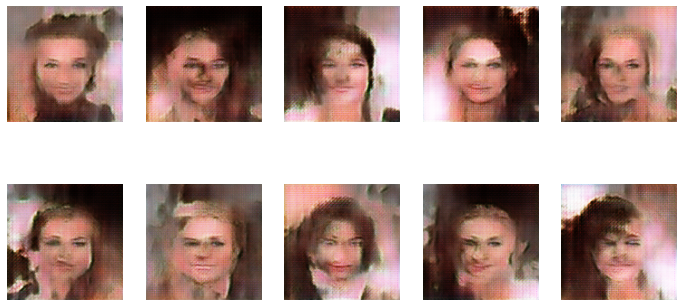

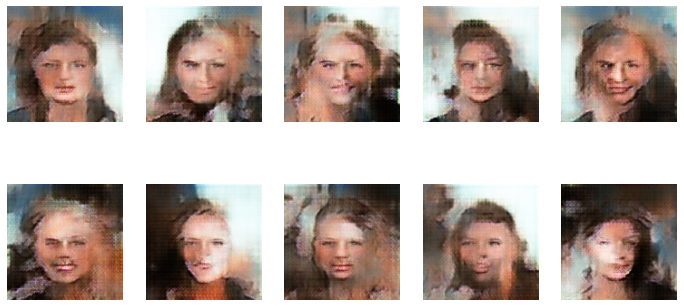

In [ ]:
#Another 4 epochs to test callbacks
epochs = 4  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), cp_callback]
)
#200k on 128x128 (callbacks worked!)

In [ ]:
#Another 20 epochs until tmr
epochs = 20  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), cp_callback]
)
#200k on 128x128 (callbacks worked!)

Epoch 1/20
6332/6332 [==============================] - 2762s 436ms/step - d_loss: 0.7033 - g_loss: 0.9605

Epoch 00001: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 2/20
6332/6332 [==============================] - 2760s 436ms/step - d_loss: 0.7046 - g_loss: 0.9550

Epoch 00002: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 3/20
6332/6332 [==============================] - 2760s 436ms/step - d_loss: 0.7058 - g_loss: 0.9564

Epoch 00003: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 4/20
6332/6332 [==============================] - 2762s 436ms/step - d_loss: 0.6985 - g_loss: 0.9439

Epoch 00004: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 5/20
6332/6332 [==============================] - 2762s 436ms/step - d_loss: 0.6957 - g_loss: 0.9591

Epoch 00005: saving model to gdrive/MyDrive/saved_files/training_callbacks/
Epoch 6/20
6332/6332 [==============================] - 2762s 436ms/step - d_los

# Conclusion
As we can see, the model somewhat generates general patterns and shapes of faces, but they don't look exaclty pretty because it was run on only 5 epochs. 
This model is very computationally expensive to run with higher number of epochs. This notebook was run on Google Colab with **Tesla P100-PCIE** GPU backend and it took roughly **2hours** just for 5 epochs. Hence, I let my model runs on Google Cloud jupyter lab with **Tesla P100** GPU backend with the same configuration and parameters. The results will be more promising on ~100 epochs.

>The results after running for 30 epochs
![](https://github.com/luongtruong77/deep-learning-fake-faces-generator/blob/main/generated_images/30epochs_64x64_full.png?raw=true)

>The results after running for 60 epochs
![](https://github.com/luongtruong77/deep-learning-fake-faces-generator/blob/main/generated_images/60epochs_64x64_full.png?raw=true)

The results typically improve with higher number of epochs.

In [ ]:
#Save the generator to reproduce the fake images

generator.save('saved_files/generator.h5')